In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cvxpy as cv
import time
import gurobipy as gp
from gurobipy import GRB
import scipy

# Independent Telegraphs with regulation

We consider a stochastic reaction network where 2 telegraph models act independently, each with a gene that switches between on and off and produces transcripts, except that the 2 transcripts regulate each other:

$ G_{1, off} \underset{k_{1, off}}{\stackrel{k_{1, on}}{\rightleftharpoons}} G_{1, on}  \quad\quad G_{2, off} \underset{k_{2, off}}{\stackrel{k_{2, on}}{\rightleftharpoons}} G_{2, on}$

$ G_{1, on} \stackrel{k_{1, tx}}\longrightarrow G_{1, on} + X_{1} \quad\quad G_{2, on} \stackrel{k_{2, tx}}\longrightarrow G_{2, on} + X_{2} $

$ X_{1} \stackrel{k_{1, deg}}\longrightarrow \varnothing \quad\quad X_{2} \stackrel{k_{2, deg}}\longrightarrow \varnothing $

$ X_{1} + X_{2} \stackrel{k_{reg}}\longrightarrow \varnothing $

Again we observe only the number of molcules of the transcripts $X_{1}$ and $X_{2}$ but not the state of the genes $G_{1}$ and $G_{2}$.

The state of the system can be written as $(x_{1}, x_{2}, g_{1}, g_{2}) \in \mathbb{N}^{2} \times \{0, 1\}^{2}$ where $0$ denotes the off state and $1$ the on state of each gene.

## Simulation

Without an explicit stationary distribution we instead use gillespie / SSA to simulate sample paths of the reaction network. After a sufficient time (burn in) we can take the state of the system as a sample from the stationary distribution.

In [3]:
rng = np.random.default_rng(2939)

In [4]:
def simulation(params, n, tmax, ts, plot=False, initial_state=(0, 0, 1, 1)):
    '''
    Simulate a sample path of the telegraph-regulation model
    Sample n values at intervals of ts after a burn-in time of tmax

    params: dict of reaction rate constants
    n: number of samples
    tmax: burn in time
    ts: time between samples
    '''

    # initialise time and state
    t = 0
    path = [initial_state]
    jump_times = [0]

    # simulate for burn-in time and time between n samples
    while t < tmax + (n - 1) * ts:

        # current state
        x1, x2, g1, g2 = path[-1][0], path[-1][1], path[-1][2], path[-1][3]

        # transition rates
        q_on_1 = (1 - g1) * params['k_on_1']
        q_on_2 = (1 - g2) * params['k_on_2']
        q_off_1 = g1 * params['k_off_1']
        q_off_2 = g2 * params['k_off_2']
        q_tx_1 = g1 * params['k_tx_1']
        q_tx_2 = g2 * params['k_tx_2']
        q_deg_1 = x1 * params['k_deg_1']
        q_deg_2 = x2 * params['k_deg_2']
        q_reg = x1 * x2 * params['k_reg']
        q_hold = q_on_1 + q_on_2 + q_off_1 + q_off_2 + q_tx_1 + q_tx_2 + \
            q_deg_1 + q_deg_2 + q_reg

        # holding time in current state
        t_hold = -np.log(rng.uniform()) / q_hold
        t += t_hold
        jump_times.append(t)

        # jump probability
        outcome = [1, 2, 3, 4, 5, 6, 7, 8, 9]
        prob = [
            q_on_1 / q_hold,
            q_on_2 / q_hold,
            q_off_1 / q_hold,
            q_off_2 / q_hold,
            q_tx_1 / q_hold,
            q_tx_2 / q_hold,
            q_deg_1 / q_hold,
            q_deg_2 / q_hold,
            q_reg / q_hold
        ]
        jump = rng.choice(outcome, p=prob)
        match jump:
            case 1:
                path.append((x1, x2, g1 + 1, g2))
            case 2:
                path.append((x1, x2, g1, g2 + 1))
            case 3:
                path.append((x1, x2, g1 - 1, g2))
            case 4:
                path.append((x1, x2, g1, g2 - 1))
            case 5:
                path.append((x1 + 1, x2, g1, g2))
            case 6:
                path.append((x1, x2 + 1, g1, g2))
            case 7:
                path.append((x1 - 1, x2, g1, g2))
            case 8:
                path.append((x1, x2 - 1, g1, g2))
            case 9:
                path.append((x1 - 1, x2 - 1, g1, g2))

    # take the transcript states
    x1_path = [state[0] for state in path]
    x2_path = [state[1] for state in path]

    # create step function of sample path from jump times and jump values
    x1_path_function = scipy.interpolate.interp1d(jump_times, x1_path, kind='previous')
    x2_path_function = scipy.interpolate.interp1d(jump_times, x2_path, kind='previous')

    # take values at sampling times as samples from stationary dist
    sample_times = [tmax + i * ts for i in range(n)]
    x1_samples = x1_path_function(sample_times)
    x2_samples = x2_path_function(sample_times)
    samples = [(int(x1_samples[i]), int(x2_samples[i])) for i in range(n)]

    # plot sample paths
    if plot:
        x = np.linspace(0, tmax + (n - 1) * ts, 10000)
        plt.plot(x, x1_path_function(x), label="X1 sample path", color="blue")
        plt.plot(x, x2_path_function(x), label="X2 sample path", color="purple")
        #plt.axvline(tmax, label="Burn-in time", color="orange")
        plt.xlabel("Time")
        plt.ylabel("# molcules")
        plt.legend()
        plt.show()

    return samples

### Example

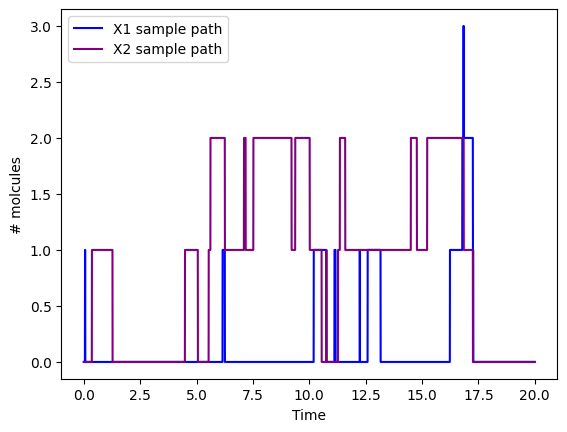

In [5]:
params = {
    'k_on_1': 1,
    'k_on_2': 1,
    'k_off_1': 1,
    'k_off_2': 1,
    'k_tx_1': 1,
    'k_tx_2': 1,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 1
}
samples = simulation(params, 2, 10, 10, plot=True)

## Bootstrap

Given samples from the staitonary distribution of the reaction network we compute confidence intervals on the probabilities of the distribution using the bootstrap. By resampling and computing the empirical distribution on each sample we can produce 95% confidence intervals.

Using a map from pairs (x1, x2) to integers x2 + (max(x1) + 1) * x2 can use efficient np.bincount to compute empirical distribution, leading to ~10x speedup. Adding a threshold on the minimum number of occurances in the original sample for CI's to be used leads to more reliable resulting bounds.

In [6]:
def bootstrap(params, n, B, tmax=100, ts=10, thresh=1, plot=False, printing=False, initial_state=(0, 0, 1, 1)):
    '''
    Compute bootstrap confidence intervals on stationary distribution by 
    simulating sample path and computing empirical distribution over 
    several bootstrap samples

    params: dict of reaction rate constants
    n: number of samples from stationary distribution
    B: number of bootstrap resamples
    tmax: burn-in time for sampling
    ts: time between samples
    thresh: minimum occurnces of a state in the original sample to use the CI
        otherwise replaced by [0, 1] bounds
    plot: toggle plotting CI's
    printing: toggle printing CI's
    initial_state: starting point of sampling
    '''

    rng = np.random.default_rng(5438)

    # simulate n samples from stationary distribution
    samples = simulation(params, n, tmax, ts, plot=False, initial_state=initial_state)

    # compute maximum x1 and x2 values
    M = np.max([sample[0] for sample in samples])
    N = np.max([sample[1] for sample in samples])

    # map (x1, x2) pairs to integers: x2 + (N + 1) * x1
    integer_samples = [sample[1] + (N + 1)*sample[0] for sample in samples]

    # maxiumum of integer sample
    D = (M + 1)*(N + 1) - 1

    # B bootstrap samples as B x n array
    bootstrap = rng.choice(integer_samples, size=(B, n))

    # offset row i by (D + 1)i
    bootstrap_offset = bootstrap + np.arange(B)[:, None]*(D + 1)

    # flatten, count occurances of each state and reshape, reversing map to give counts of each (x1, x2) pair
    counts = np.bincount(bootstrap_offset.ravel(), minlength=B*(D + 1)).reshape(-1, M + 1, N + 1)

    # counts to probability
    counts = counts / n

    # sum over columns / rows to give counts of each x1 / x2 state
    x1_counts = counts.sum(axis=2)
    x2_counts = counts.sum(axis=1)

    # compute 2.5% and 97.5% quantiles for each p(x1, x2), p(x1) and p(x2)
    bounds = np.quantile(counts, [0.025, 0.975], axis=0)
    x1_bounds = np.quantile(x1_counts, [0.025, 0.975], axis=0)
    x2_bounds = np.quantile(x2_counts, [0.025, 0.975], axis=0)

    # count occurances per (x1, x2) in the in original sample
    sample_counts = np.bincount(integer_samples, minlength=D + 1).reshape(M + 1, N + 1)

    # sum over columns / rows to give counts per x1 / x2 state
    x1_sample_counts = sample_counts.sum(axis=1)
    x2_sample_counts = sample_counts.sum(axis=0)

    # replace CI's for states below threshold occurances by [0, 1] bounds
    for x1 in range(M + 1):
        for x2 in range(N + 1):
            if sample_counts[x1, x2] < thresh:
                bounds[:, x1, x2] = [0.0, 1.0]

    for x1 in range(M + 1):
        if x1_sample_counts[x1] < thresh:
            x1_bounds[:, x1] = [0.0, 1.0]

    for x2 in range(N + 1):
        if x2_sample_counts[x2] < thresh:
            x2_bounds[:, x2] = [0.0, 1.0]

    # plotting
    if plot:
        fig, axs = plt.subplots(M + 1, N + 1, figsize=(10, 10))
        fig.tight_layout()
        for x1 in range(M + 1):
            for x2 in range(N + 1):
                axs[x1, x2].hist(counts[:, x1, x2])
                axs[x1, x2].set_title(f"p({x1}, {x2})")
                axs[x1, x2].axvline(bounds[0, x1, x2], color="red")
                axs[x1, x2].axvline(bounds[1, x1, x2], color="red")

        plt.suptitle("X1 X2 Confidence Intervals")
        plt.show()

        fig, axs = plt.subplots(1, M + 1, figsize=(10, 3))
        fig.tight_layout()
        for x1 in range(M + 1):
            axs[x1].hist(x1_counts[:, x1])
            axs[x1].set_title(f"p({x1})")
            axs[x1].axvline(x1_bounds[0, x1], color="red")
            axs[x1].axvline(x1_bounds[1, x1], color="red")

        plt.suptitle("X1 Confidence Intervals")
        plt.show()

        fig, axs = plt.subplots(1, N + 1, figsize=(10, 3))
        fig.tight_layout()
        for x2 in range(N + 1):
            axs[x2].hist(x2_counts[:, x2])
            axs[x2].set_title(f"p({x2})")
            axs[x2].axvline(x2_bounds[0, x2], color="red")
            axs[x2].axvline(x2_bounds[1, x2], color="red")

        plt.suptitle("X2 Confidence Intervals")
        plt.show()

    return {'joint': bounds, 'x1': x1_bounds, 'x2': x2_bounds}

In [6]:
def bootstrap_old(params, n, B, tmax=100, ts=10, plot=False, printing=False, initial_state=(0, 0, 1, 1)):
    '''
    Compute bootstrap confidence intervals on the stationary distribution of system
    Simulate sample path and compute empirical distribution over each bootstrap sample

    params: dict of reaction rate constants
    n: number of samples from the stationary distribution
    B: number of bootstrap resamples
    tmax: burn-in time for sampling
    ts: time between samples
    plot: toggle plotting CI's
    printing: toggle printing CI's
    initial_state: starting point of sampling
    '''

    # n samples from stationary distribution
    samples = simulation(params, n, tmax, ts, plot=False, initial_state=initial_state)

    # separate x1 and x2 values (always considered paired, but for computational reasons)
    x1_samples = [sample[0] for sample in samples]
    x2_samples = [sample[1] for sample in samples]

    # maximum values found (+ 1)
    M = np.max(x1_samples) + 1
    N = np.max(x2_samples) + 1

    # array to count occurances per state per bootstrap sample
    counts = np.zeros((B, M, N))
    x1_counts = np.zeros((B, M))
    x2_counts = np.zeros((B, N))

    # B bootstrap samples of size n in B x n array
    boot = rng.choice(samples, size=(B, n))

    # loop over each sample (row) and add to counts
    for b in range(B):
        for i in range(n):
            x1, x2 = boot[b, i]
            counts[b, x1, x2] += 1
            x1_counts[b, x1] += 1
            x2_counts[b, x2] += 1

    # normalize counts to probabilities
    counts /= n
    x1_counts /= n
    x2_counts /= n

    # take 2.5%, 97.5% percentiles for each p(x1, x2)
    # gives 2 x M x N array of lower and upper bounds (axis 0) for each p(x1, x2)
    bounds = np.quantile(counts, [0.025, 0.975], axis=0)
    x1_bounds = np.quantile(x1_counts, [0.025, 0.975], axis=0)
    x2_bounds = np.quantile(x2_counts, [0.025, 0.975], axis=0)

    # plotting
    if plot:
        fig, axs = plt.subplots(M, N, figsize=(10, 10))
        fig.tight_layout()
        for x1 in range(M):
            for x2 in range(N):
                axs[x1, x2].hist(counts[:, x1, x2])
                axs[x1, x2].set_title(f"p({x1}, {x2})")
                axs[x1, x2].axvline(bounds[0, x1, x2], color="red")
                axs[x1, x2].axvline(bounds[1, x1, x2], color="red")

        plt.suptitle("X1 X2 Confidence Intervals")
        plt.show()

        fig, axs = plt.subplots(1, M, figsize=(10, 3))
        fig.tight_layout()
        for x1 in range(M):
            axs[x1].hist(x1_counts[:, x1])
            axs[x1].set_title(f"p({x1})")
            axs[x1].axvline(x1_bounds[0, x1], color="red")
            axs[x1].axvline(x1_bounds[1, x1], color="red")

        plt.suptitle("X1 Confidence Intervals")
        plt.show()

        fig, axs = plt.subplots(1, N, figsize=(10, 3))
        fig.tight_layout()
        for x2 in range(N):
            axs[x2].hist(x2_counts[:, x2])
            axs[x2].set_title(f"p({x2})")
            axs[x2].axvline(x2_bounds[0, x2], color="red")
            axs[x2].axvline(x2_bounds[1, x2], color="red")

        plt.suptitle("X2 Confidence Intervals")
        plt.show()

    return {'joint': bounds, 'x1': x1_bounds, 'x2': x2_bounds}

### Example

In [17]:
bounds = bootstrap_old(params, 5000, 5000, plot=False)

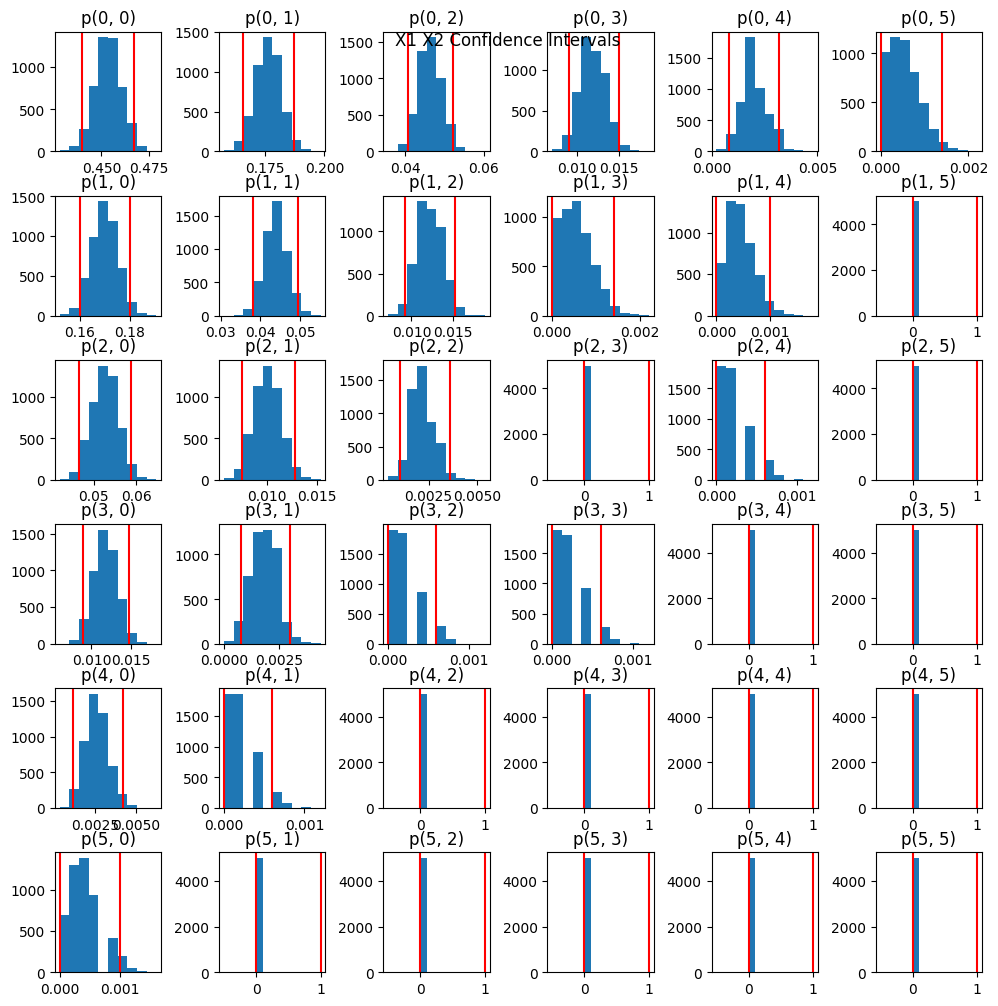

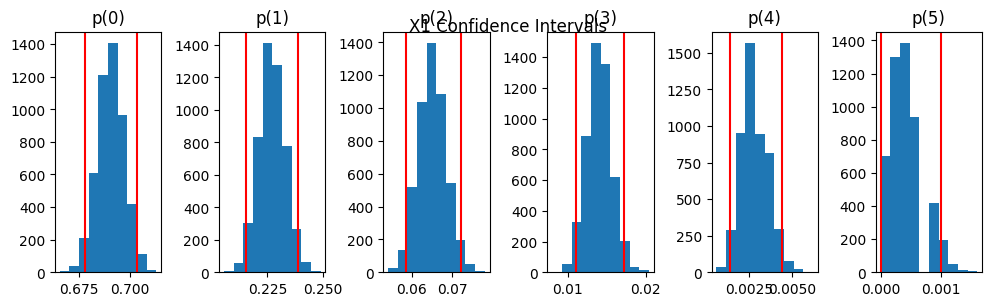

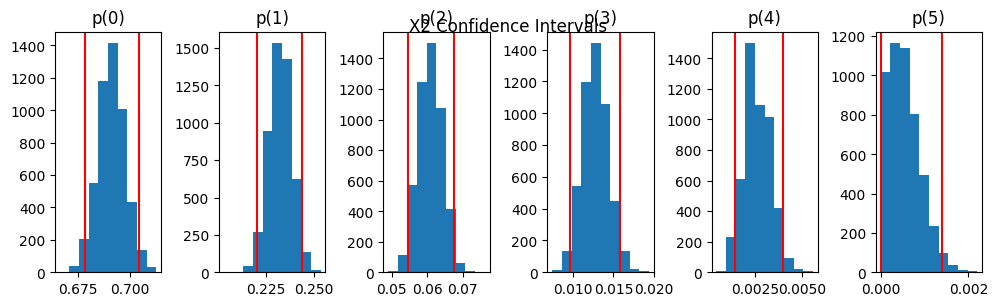

In [7]:
bounds = bootstrap(params, 5000, 5000, plot=True)

## Optimization

In [32]:
def optimization(params, bounds, N=None, M=None, K=10, silent=True, print_solution=True, test_feasible=False, param_bounds=None,
                 time_limit=300, MIPGap=0.0004, Heuristics=0.05, presolve=-1, maxim=True):
    '''
    Non-linear optimization to produce bounds on parameters of interest

    params: variable or fixed reaction rate constants
    bounds: 2 x M x N array of confidence interval bounds on stat. dist. of system
    silent: toggle printing of optimization status
    '''

    # create model
    md = gp.Model('telegraph-regulation')

    # settings
    if silent:
        md.Params.LogToConsole = 0

    # 5 minute time limit
    md.Params.TimeLimit = time_limit

    # optimization settings
    md.Params.MIPGap = MIPGap
    md.Params.Heuristics = Heuristics
    md.Params.Presolve = presolve

    # size
    if not M:
        M = bounds.shape[1]
    if not N:
        N = bounds.shape[2]

    # variables

    # stationary distribution
    p = md.addMVar(shape=(M, N, 2, 2), vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)

    # reaction rate constants
    rate_names = ['k_on_1', 'k_on_2', 'k_off_1', 'k_off_2', 'k_tx_1', 'k_tx_2', 'k_deg_1', 'k_deg_2', 'k_reg']
    rates = md.addVars(rate_names, vtype=GRB.CONTINUOUS, lb=0, ub=K, name=rate_names)

    # constraints

    # set fixed values
    for name, value in params.items():
        if value == "v" or value == "vo":
            pass
        else:
            md.addConstr(rates[name] == value)

    # add any bounds given
    try:
        for name, value in param_bounds.items():
            md.addConstr(rates[name] <= value[1])
            md.addConstr(rates[name] >= value[0])
    except AttributeError:
        pass

    # (marginal) stationary distribution bounds
    for x1 in range(M):
        for x2 in range(N):
            md.addConstr(bounds['joint'][0, x1, x2] <= p[x1, x2, 0, 0] + p[x1, x2, 1, 0] + p[x1, x2, 0, 1] + p[x1, x2, 1, 1], name=f"Marginal lb {x1}, {x2}")
            md.addConstr(bounds['joint'][1, x1, x2] >= p[x1, x2, 0, 0] + p[x1, x2, 1, 0] + p[x1, x2, 0, 1] + p[x1, x2, 1, 1], name=f"Marginal ub {x1}, {x2}")

    # additional frechet bounds
    for x1 in range(M):
        for x2 in range(N):
            for g1 in [0, 1]:
                for g2 in [0, 1]:
                    # expressions for p(g1) and p(g2)
                    
                    # add new variables
                    p_g1 = md.addVar(vtype=GRB.CONTINUOUS, name='p_g1')
                    p_g2 = md.addVar(vtype=GRB.CONTINUOUS, name='p_g2')

                    # set equal to values
                    if g1 == 1:
                        md.addConstr(p_g1 * (rates['k_on_1'] + rates['k_off_1']) == rates['k_on_1'])
                    else:
                        md.addConstr(p_g1 * (rates['k_on_1'] + rates['k_off_1']) == rates['k_off_1'])
                    if g2 == 1:
                        md.addConstr(p_g2 * (rates['k_on_2'] + rates['k_off_2']) == rates['k_on_2'])
                    else:
                        md.addConstr(p_g2 * (rates['k_on_2'] + rates['k_off_2']) == rates['k_off_2'])

                    # use in bounds
                    md.addConstr(p[x1, x2, g1, g2] >= bounds['x1'][0, x1] + bounds['x2'][0, x2] + p_g1 + p_g2 - 3, name="Frechet all lb")
                    md.addConstr(p[x1, x2, g1, g2] >= bounds['joint'][0, x1, x2] + p_g1 + p_g2 - 2, name="Frechet joint lb")
                    md.addConstr(p[x1, x2, g1, g2] <= bounds['joint'][1, x1, x2])
                    md.addConstr(p[x1, x2, g1, g2] <= bounds['x1'][1, x1])
                    md.addConstr(p[x1, x2, g1, g2] <= bounds['x2'][1, x2])
                    md.addConstr(p[x1, x2, g1, g2] <= p_g1)
                    md.addConstr(p[x1, x2, g1, g2] <= p_g2)

    # distribution
    md.addConstr(p.sum() <= 1, name="Distribution")
    
    # stationary Qp=0 equations for all relevant variables
    for x1 in range(M - 1):
        for x2 in range(N - 1):
            for g1 in [0, 1]:
                for g2 in [0, 1]:
                    if x1 == 0:
                        x1_zero = 0
                    else:
                        x1_zero = 1
                    if x2 == 0:
                        x2_zero = 0
                    else:
                        x2_zero = 1

                    md.addConstr( 
                        rates['k_on_1'] * g1 * p[x1, x2, 0, g2] + \
                        rates['k_on_2'] * g2 * p[x1, x2, g1, 0] + \
                        rates['k_off_1'] * (1 - g1) * p[x1, x2, 1, g2] + \
                        rates['k_off_2'] * (1 - g2) * p[x1, x2, g1, 1] + \
                        # need to remove this when x1 or x2 = 0, since not in equation (index = -1 crrently taking end of array)
                        # so multiply by toggle
                        rates['k_tx_1'] * g1 * x1_zero * p[x1 - 1, x2, g1, g2] + \
                        rates['k_tx_2'] * g2 * x2_zero * p[x1, x2 - 1, g1, g2] + \
                        rates['k_deg_1'] * (x1 + 1) * p[x1 + 1, x2, g1, g2] + \
                        rates['k_deg_2'] * (x2 + 1) * p[x1, x2 + 1, g1, g2] + \
                        rates['k_reg'] * (x1 + 1) * (x2 + 1) * p[x1 + 1, x2 + 1, g1, g2] - \
                        (rates['k_on_1'] * (1 - g1) + rates['k_on_2'] * (1 - g2) + \
                         rates['k_off_1'] * g1 + rates['k_off_2'] * g2 + \
                         rates['k_tx_1'] * g1 + rates['k_tx_2'] * g2 + \
                         rates['k_deg_1'] * x1 + rates['k_deg_2'] * x2 + \
                         rates['k_reg'] * x1 * x2) * p[x1, x2, g1, g2] == 0,
                        name=f"Equation {x1}, {x2}, {g1}, {g2}"
                    )

    # status of optimization
    status_codes = {1: 'LOADED',
                    2: 'OPTIMAL',
                    3: 'INFEASIBLE',
                    4: 'INF_OR_UNBD',
                    5: 'UNBOUNDED',
                    6: 'CUTOFF',
                    7: 'ITERATION_LIMIT',
                    8: 'NODE_LIMIT',
                    9: 'TIME_LIMIT',
                    10: 'SOLUTION_LIMIT',
                    11: 'INTERRUPTED',
                    12: 'NUMERIC',
                    13: 'SUBOPTIMAL',
                    14: 'INPROGRESS',
                    15: 'USER_OBJ_LIMIT'}

    # solution dict
    solution = {}

    # optimize
    for name, value in params.items():

        # variable
        if value == "vo":

            # minimize
            md.setObjective(rates[name], GRB.MINIMIZE)
            try:
                md.optimize()
                min_val = md.ObjVal
            except:
                min_val = None
                
            # decode status: store result
            status_min = status_codes[md.status]

            # maximize (if needed)
            if maxim:
                md.setObjective(rates[name], GRB.MAXIMIZE)
                try:
                    md.optimize()
                    max_val = md.ObjVal
                except:
                    max_val = None

                # decode status: store result
                status_max = status_codes[md.status]

            # store
            if maxim:
                solution[name] = [min_val, max_val, status_min, status_max]
            else:
                solution[name] = [min_val, status_min]
    
        # constant
        else:
            solution[name] = value

    md.Params.DualReductions = 0

    if test_feasible:
        # if testing feasibility simply optimize 0 to check
        md.setObjective(0, GRB.MINIMIZE)

        # set parameter (prevents 'infeasible or unbounded' ambiguity)
        md.Params.DualReductions = 0

        # set solution limit (stop after finding 1 feasible solution)
        md.Params.SolutionLimit = 1

        try:
            md.optimize()
            status_code = md.status
        except:
            status_code = md.status

        # decode status: store result
        solution['feasible'] = status_codes[status_code]

    # print
    if print_solution:
        for key, val in solution.items():
            if key == 'feasible':
                print(f"Model is {val}")
            elif type(val) == list:
                if maxim:
                    print(f"{key} in ({val[0]}, {val[1]}), status {val[2]} {val[3]}")
                else:
                    print(f"{key} lower bound {val[0]}, status {val[1]}")
            elif val == "v":
                print(f"{key} variable, not optimized")
            else:
                print(f"{key} = {val}")

    # return model for IIS, etc
    solution['model'] = md

    return solution

In [21]:
# choose variables / variables to optimize over / fixed parameters for optimization
params_optim = {
    'k_on_1': 1,
    'k_on_2': 1,
    'k_off_1': "v",
    'k_off_2': "v",
    'k_tx_1': "vo",
    'k_tx_2': "vo",
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 1
}

# optimize
solution = optimization(params_optim, bounds, M=3, N=3, silent=True, test_feasible=True)

k_on_1 = 1
k_on_2 = 1
k_off_1 variable, not optimized
k_off_2 variable, not optimized
k_tx_1 in (0.17741224065043926, 10.0), status OPTIMAL OPTIMAL
k_tx_2 in (0.2259675628994228, 10.0), status OPTIMAL OPTIMAL
k_deg_1 = 1
k_deg_2 = 1
k_reg = 1
Model is SOLUTION_LIMIT


## Testing for interaction

Given simulated, or real, data from a reaction network we want to know if there is interaction between 2 species of transcripts, $X_{1}$ and $X_{2}$ produced by different genes, or if there is none and they obey independent telegraph models i.e. $k_{reg} = 0$.

### Method 1:

Fix a parameter of the reaction network for identifiability e.g. $k_{deg_2} = 1$ and optimize for $k_{reg}$. If the resulting bounds do not contain 0 (non-zero lower bound) this suggests there is interaction in the system, up to 95% confidence of the bounds used.

### Method 2:

Assume as a null hypothesis there is no interaction, $H_{0}: k_{reg} = 0$, and so the stationary distribution factorises into 2 independent distributions:

$ p(x_1, x_2) = p(x_1)p(x_2) $

$ x_{1} \vert \rho_{1} \sim \text{Poi}\left(\frac{k_{tx_1}}{k_{deg_1}}\rho_{1} \right) \quad \rho_{1} \sim \text{Beta}\left(\frac{k_{on_1}}{k_{deg_1}}, \frac{k_{off_1}}{k_{deg_1}} \right)$

$ x_{2} \vert \rho_{2} \sim \text{Poi}\left(\frac{k_{tx_2}}{k_{deg_2}}\rho_{2} \right) \quad \rho_{2} \sim \text{Beta}\left(\frac{k_{on_2}}{k_{deg_2}}, \frac{k_{off_2}}{k_{deg_2}} \right)$

Fixing 1 parameter in each of the ratios e.g. $k_{deg_1} = 1$ and $k_{deg_2} = 1 $, leaves the stationary distribution unchanged and so given only data from the stationary distribution allows identifiability of the parameters.

Fixing $k_{reg} = 0$, an infeasible solution suggests that the data is not consistent with a model of no interaction. However, a feasible solution to the optimization problem suggests there are parameter values that together with the data satisfy a model of no interaction, but does not confirm that there is no interaction.

NOTE: do not need to optimize, but simply check feasibility / infeasiblity status of problem

#### Test: data with high interaction

Simulate data with a large interaction parameter ($k_{reg} = 10$ relative to 1 for other parameters), and see if this can be deduced from the data

NOTE: also choose favourable parameter values for on / off rates 

In [22]:
# parameter values for simulation: large regulation
params_simul = {
    'k_on_1': 0.9,
    'k_on_2': 0.9,
    'k_off_1': 0.1,
    'k_off_2': 0.1,
    'k_tx_1': 1,
    'k_tx_2': 1,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 10
}

# optimize over regulation parameter (method 1)
params_optim_var = {
    'k_on_1': "v", 
    'k_on_2': "v",
    'k_off_1': "v",
    'k_off_2': "v",
    'k_tx_1': "v",
    'k_tx_2': "v",
    'k_deg_1': "v",
    'k_deg_2': 1,
    'k_reg': "vo"
}

# fix regulation parameter to 0 (method 2)
params_optim_zero = {
    'k_on_1': "v", 
    'k_on_2': "v",
    'k_off_1': "v",
    'k_off_2': "v",
    'k_tx_1': "v",
    'k_tx_2': "v",
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 0
}

In [23]:
# simulate and bootstrap to produce CI bounds on stat. dist.
bounds_test = bootstrap(params_simul, 5000, 5000, thresh=10, plot=False)
bounds_test['joint'].shape

(2, 6, 6)

In [24]:
# method 1: leave k_reg variable, use data with high regulation, optimize
solution_test = optimization(params_optim_var, bounds_test, M=4, N=4, K=20, silent=False, test_feasible=False, MIPGap=0.05, Heuristics=0.2)

Set parameter TimeLimit to value 300
Set parameter MIPGap to value 0.05
Set parameter Heuristics to value 0.2
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 482 rows, 201 columns and 1025 nonzeros
Model fingerprint: 0x225314a0
Model has 164 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 9e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [2e-03, 3e+00]
Presolve removed 279 rows and 1 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 269 rows and 1 columns
Presolve time: 0.01s
Presolved: 2121 rows, 636 columns, 4840 nonzeros
Presolved model has 436 bilinear constraint(s)
Variable types: 636 continuous,

In [38]:
# use more CI bounds
solution_test = optimization(params_optim_var, bounds_test, M=5, N=5, K=20, silent=False, test_feasible=False,
                             MIPGap=0.05, Heuristics=1.0, time_limit=300, presolve=2, maxim=False)

Set parameter TimeLimit to value 300
Set parameter MIPGap to value 0.05
Set parameter Heuristics to value 1
Set parameter Presolve to value 2
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 752 rows, 309 columns and 1601 nonzeros
Model fingerprint: 0x122d1a68
Model has 264 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 2e+01]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [8e-04, 3e+00]
Presolve removed 439 rows and 1 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 427 rows and 1 columns
Presolve time: 0.00s
Presolved: 3469 rows, 1028 columns, 7948 nonzeros
Presolved model has 720 bilinear constraint(s

In [98]:
# method 1: leave k_reg variable, use data with high regulation, optimize
solution_test = optimization(params_optim_var, bounds_test, M=4, N=4, K=20, silent=False, test_feasible=False)

Set parameter TimeLimit to value 300
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 482 rows, 201 columns and 1025 nonzeros
Model fingerprint: 0x1dbae50d
Model has 164 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 9e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e-03, 3e+00]
Presolve removed 279 rows and 1 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 269 rows and 1 columns
Presolve time: 0.03s
Presolved: 2121 rows, 636 columns, 4840 nonzeros
Presolved model has 436 bilinear constraint(s)
Variable types: 636 continuous, 0 integer (0 binary)
Found heuristic solution: objective 0.0693842

Root

A non-zero lower bound on $k_{reg}$ suggests, as expected, that there is interaction between the 2 transcripts.

Using more CI bounds can improve the lower bound, but in general optimizations are slow and may fail to produce any bound before being terminated early by a 5 / 10 minute time limit (or produce a bound but are terminated before showing optimality)

Many of the lower bounds produced are via the heuristic solution and are not improved on despite lengthy exploration of the branch-and-bound tree, so changing parameters to focus more time on this helps improve results:

Presolve = 2 to be more aggressive reducing problem size
Heuristic = 1.0 to spend more time finding heuristic solutions

The solver rarely seems to find other feasible solutions (primal or dual) leaving the MIPgap at 100% throughout exploration, but in other cases it may be beneficial to set a larger threshold value e.g. 5%, to prevent time being wasted on small improvements to bounds, as the main objective is to determine if a non-zero lower bound exists.

(Potential to terminate the optimization early if the lower bound on the minimization can be proven to be non-zero e.g. dual feasible solutions, etc)

In [88]:
# method 2: fix k_reg = 0, use data with high regulation, test feasibility
solution_test = optimization(params_optim_zero, bounds_test, M=6, N=6, K=20, silent=False, test_feasible=True,
                             time_limit=600)

Set parameter TimeLimit to value 600
Set parameter DualReductions to value 0
Set parameter SolutionLimit to value 1
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1684 rows, 681 columns and 3587 nonzeros
Model fingerprint: 0x4f6a6a95
Model has 616 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 4e+01]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e-03, 3e+00]
Presolve removed 991 rows and 3 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 987 rows and 3 columns
Presolve time: 0.01s
Presolved: 6913 rows, 2078 columns, 15914 nonzeros
Presolved model has 1400 bilinear constraint(s)
Variable types: 2078 

Proving the model is infeasible requires checking all nodes in the branch-and-bound tree and so is very time intensive (whereas to show feasibility can stop immediately after 1 feasible point is found).

A time limit is set to prevent model running 'forever', and 10 minutes is too short to explore all nodes

##### Conclusions

While the lack of optimization in method 2 is attractive, even with additional constraints from a 2 step method (see below section) showing the model is infeasible is simply too time intensive to be practical. Gurobi must explore the full branch and bound tree to prove all nodes are infeasible (or discarded) and can only stop after a single feasible point is found or the full tree explored (so setting a time limit gives an inconclusive result)

Despite method 1 requiring optimization of the lower bound on $k_{reg}$ and having more variable parameters it delivers much more promising results. Setting Gurobi model parameters to spend more time on presolving and initial heuristics (where most solutions are found) usually leads to good non-zero lower bounds, although are rarely improved by branch-and-bound tree exploration (sometimes slightly improved, and rarely an objective bound allows MIPGap termination OR proof of a non-zero optimal solution even if time limit termination occurs)

For harder problems using data with a smaller interaction paramter we will focus on method 1 and tuning gurobi model parameters to best test for interaction

#### Test: data with medium interaction

Simulate data with a medium interaction parameter ($k_{reg} = 1$ roughly the same magnitude as other parameters), and see if this can be deduced from the data

NOTE: also choose favourable parameter values for on / off rates 

In [89]:
# parameter values for simulation: large regulation
params_simul = {
    'k_on_1': 0.9,
    'k_on_2': 0.9,
    'k_off_1': 0.1,
    'k_off_2': 0.1,
    'k_tx_1': 1,
    'k_tx_2': 1,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 1
}

# optimize over regulation parameter (method 1)
params_optim_var = {
    'k_on_1': "v", 
    'k_on_2': "v",
    'k_off_1': "v",
    'k_off_2': "v",
    'k_tx_1': "v",
    'k_tx_2': "v",
    'k_deg_1': "v",
    'k_deg_2': 1,
    'k_reg': "vo"
}

# fix regulation parameter to 0 (method 2)
params_optim_zero = {
    'k_on_1': "v", 
    'k_on_2': "v",
    'k_off_1': "v",
    'k_off_2': "v",
    'k_tx_1': "v",
    'k_tx_2': "v",
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 0
}

In [90]:
# simulate and bootstrap to produce CI bounds on stat. dist.
bounds_test = bootstrap(params_simul, 5000, 5000, thresh=10, plot=False)
bounds_test['joint'].shape

(2, 6, 7)

In [94]:
# method 1: leave k_reg variable, use data with high regulation, optimize
solution_test = optimization(params_optim_var, bounds_test, M=6, N=7, K=20, silent=True, test_feasible=False)

k_on_1 variable, not optimized
k_on_2 variable, not optimized
k_off_1 variable, not optimized
k_off_2 variable, not optimized
k_tx_1 variable, not optimized
k_tx_2 variable, not optimized
k_deg_1 variable, not optimized
k_deg_2 = 1
k_reg in (9.31813585068158e-07, 0.6323080476694456), status TIME_LIMIT TIME_LIMIT


Lower bound is non-zero which suggests interaction, but very close to 0 so should be careful when drawing conclusions (but in this case we know it is correct there is interaction)

Again the optimization is time intensive, which may be improved with better settings.

Interestingly the upper bound on $k_{reg}$ is quite low, giving a narrow interval and some insight into the strength of the interaction effect (it is not technically neccesary to optimize for the upper bound, but seems to give interesting information)

In [95]:
# method 2: fix k_reg = 0, use data with high regulation, test feasibility
solution_test = optimization(params_optim_zero, bounds_test, M=6, N=7, K=20, silent=False, test_feasible=True, time_limit=600)

Set parameter TimeLimit to value 600
Set parameter DualReductions to value 0
Set parameter SolutionLimit to value 1
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1264 rows, 513 columns and 2691 nonzeros
Model fingerprint: 0xe162ec09
Model has 456 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 3e+01]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [2e-03, 3e+00]
Presolve removed 741 rows and 3 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 729 rows and 3 columns
Presolve time: 0.01s
Presolved: 5119 rows, 1542 columns, 11782 nonzeros
Presolved model has 1032 bilinear constraint(s)
Variable types: 1542 

A similar issue as with higher interaction data, examining the full branch-and-bound tree to show infeasibility is simply too time intensive to be reasonable

#### Test: data with low interaction

#### Test: data with no interaction

## 2 Step method

Following method 2 and assuming a hypothesis of no interaction we have that each transcript, $X_{1}$ and $X_{2}$, follows an independent telegraph model. Taking the $x_{1}$ and $x_{2}$ counts from the sample we can optimize 2 models to bound $k_{tx_1}$ and $k_{tx_2}$, and use the resulting bounds as additional constraints in optimization of the full model (where we fix $k_{reg}=0$ as assumed).

NOTE: in the optimizations it is important to fix the parameters $k_{deg_1}$ and $k_{deg_2}$ to the same values (to ensure identifiability, with the assumption of independence allowing fixing of both)

In [10]:
def optimization_single(params, bounds, tr=1, M=None, K=10, silent=True, print_solution=True, test_feasible=False, time_limit=300):
    """
    Solve Non-Linear Programming problem to bound parameters

    Inputs:
    params: [k_on, k_off, k_tx, k_deg] either values that will be fixed, or "v"
        for variable to be bounded
    N: number of rows/equations of Qp = 0 to use in constraints
        must be even
    intervals: list of confidence intervals for at least N/2 + 1 marginal states
    K: upper bound on params (k's) for computational reasons
    frechet_bounds: bool to include additionally derived 'frechet' constraints
    print_solution: bool to print solution bounds
    printing: bool to print optimizer information
    """

    # create model
    md = gp.Model("gene_exp")

    # set options
    if silent:
        md.Params.LogToConsole = 0

    # set 5 minute time limit
    md.Params.TimeLimit = time_limit

    # size
    if not M:
        M = bounds.shape[1]

    # variables

    # stationary distribution
    p = md.addMVar(shape=(M, 2), vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)

    # reaction rate constants
    rate_names = [f'k_on_{tr}', f'k_off_{tr}', f'k_tx_{tr}', f'k_deg_{tr}']
    rates = md.addVars(rate_names, vtype=GRB.CONTINUOUS, lb=0, ub=K, name=rate_names)

    # constraints

    # set fixed values
    for name, value in params.items():
        if value == "v" or value == "vo":
            pass
        else:
            md.addConstr(rates[name] == value)

    # (marginal) stationary dist bounds
    for x in range(M):
        md.addConstr(bounds[f'x{tr}'][0, x] <= p[x, 0] + p[x, 1], name=f"Marginal lb {x}")
        md.addConstr(bounds[f'x{tr}'][1, x] >= p[x, 0] + p[x, 1], name=f"Marginal ub {x}")

    # additional frechet bounds
    for x in range(M):
        # g = 1
        md.addConstr((rates[f'k_on_{tr}'] + rates[f'k_off_{tr}']) * p[x, 1] <= rates[f'k_on_{tr}'], name=f"Frechet ub {x}, {1}")
        # g = 0
        md.addConstr((rates[f'k_on_{tr}'] + rates[f'k_off_{tr}']) * p[x, 0] <= rates[f'k_off_{tr}'], name=f"Frechet ub {x}, {0}")

    # distribution
    md.addConstr(p.sum() <= 1, name="Distribution")

    # stationary Qp=0 equations for all relevant variables
    for x in range(M - 1):
        for g in [0, 1]:
            if x == 0:
                x_zero = 0
            else:
                x_zero = 1

            md.addConstr( 
                rates[f'k_on_{tr}'] * g * p[x, 0] + \
                rates[f'k_off_{tr}'] * (1 - g) * p[x, 1] + \
                # need to remove this when x = 0, since not in equation (index = -1 crrently taking end of array)
                # so multiply by toggle
                rates[f'k_tx_{tr}'] * g * x_zero * p[x - 1, g] + \
                rates[f'k_deg_{tr}'] * (x + 1) * p[x + 1, g] - \
                (rates[f'k_on_{tr}'] * (1 - g) + \
                 rates[f'k_off_{tr}'] * g + \
                 rates[f'k_tx_{tr}'] * g + \
                 rates[f'k_deg_{tr}'] * x) * p[x, g] == 0,
                name=f"Equation {x}, {g}"
            )

    # solution dict
    solution = {}

    # optimize
    for name, value in params.items():

        # variable
        if value == "vo":

            # minimize
            md.setObjective(rates[name], GRB.MINIMIZE)
            try:
                md.optimize()
                min_val = md.ObjVal
            except:
                min_val = None

            # maximize
            md.setObjective(rates[name], GRB.MAXIMIZE)
            try:
                md.optimize()
                max_val = md.ObjVal
            except:
                max_val = None

            # store
            solution[name] = [min_val, max_val]
    
        # constant
        else:
            solution[name] = value
    
    if test_feasible:
        # if testing feasibility simply optimize 0 to check
        md.setObjective(0, GRB.MINIMIZE)

        # set parameter (prevents 'infeasible or unbounded' ambiguity)
        md.Params.DualReductions = 0
        try:
            md.optimize()
            status_code = md.status
        except:
            status_code = md.status

        # decode status
        status_codes = {1: 'LOADED',
                        2: 'OPTIMAL',
                        3: 'INFEASIBLE',
                        4: 'INF_OR_UNBD',
                        5: 'UNBOUNDED',
                        6: 'CUTOFF',
                        7: 'ITERATION_LIMIT',
                        8: 'NODE_LIMIT',
                        9: 'TIME_LIMIT',
                        10: 'SOLUTION_LIMIT',
                        11: 'INTERRUPTED',
                        12: 'NUMERIC',
                        13: 'SUBOPTIMAL',
                        14: 'INPROGRESS',
                        15: 'USER_OBJ_LIMIT'}

        # store result
        solution['feasible'] = status_codes[status_code]

    # print
    if print_solution:
        for key, val in solution.items():
            if key == 'feasible':
                print(f"Model is {val}")
            elif type(val) == list:
                print(f"{key} in ({val[0]}, {val[1]})")
            elif val == "v":
                print(f"{key} variable, not optimized")
            else:
                print(f"{key} = {val}")

    # return model for IIS, etc
    solution['model'] = md

    return solution

### Example

In [13]:
# parameter values for simulation
params_simul = {
    'k_on_1': 0.9,
    'k_on_2': 0.9,
    'k_off_1': 0.1,
    'k_off_2': 0.1,
    'k_tx_1': 1,
    'k_tx_2': 1,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 10
}

# parameter settings for full optimization (method 2)
params_optim_zero = {
    'k_on_1': "v",
    'k_on_2': "v",
    'k_off_1': "v",
    'k_off_2': "v",
    'k_tx_1': "v",
    'k_tx_2': "v",
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 0
}

# parameter settings for optimization over x1 counts
params_optim_x1 = {
    'k_on_1': "vo",
    'k_off_1': "vo",
    'k_tx_1': "vo",
    'k_deg_1': 1
}

# parameter settings for optimization over x2 counts
params_optim_x2 = {
    'k_on_2': "vo",
    'k_off_2': "vo",
    'k_tx_2': "vo",
    'k_deg_2': 1
}

In [14]:
# simulate and bootstrap to produce CI bounds on stat. dist.
bounds_test = bootstrap(params_simul, 5000, 5000, thresh=10, plot=False)
bounds_test['joint'].shape

(2, 7, 8)

In [15]:
# optimize birth death using x1 bounds
solution_x1 = optimization_single(params_optim_x1, bounds_test, tr=1, M=7, test_feasible=True)

k_on_1 in (0.0, 1.7520298512312635)
k_off_1 in (0.0, 10.0)
k_tx_1 in (0.6013485213064994, 5.084245163054403)
k_deg_1 = 1
Model is OPTIMAL


In [16]:
# optimize birth death using x2 bounds
solution_x2 = optimization_single(params_optim_x2, bounds_test, tr=2, M=8, test_feasible=True)

k_on_2 in (0.17246656121578485, 1.9278917748821622)
k_off_2 in (0.1220651412540995, 10.0)
k_tx_2 in (0.7729872278690796, 5.1206583034670095)
k_deg_2 = 1
Model is OPTIMAL


In [17]:
# collect bounds on parameters
param_bounds = {
    'k_on_1': solution_x1['k_on_1'],
    'k_on_2': solution_x2['k_on_2'],
    'k_off_1': solution_x1['k_off_1'],
    'k_off_2': solution_x2['k_off_2'],
    'k_tx_1': solution_x1['k_tx_1'],
    'k_tx_2': solution_x2['k_tx_2']
}

In [19]:
# method 2: fix k_reg = 0, use data with high regulation, test feasibility
solution_test = optimization(params_optim_zero, bounds_test, M=7, N=8, K=20, silent=False, test_feasible=True, param_bounds=param_bounds,
 time_limit=600)

Set parameter TimeLimit to value 600
Set parameter DualReductions to value 0
Set parameter SolutionLimit to value 1
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1696 rows, 681 columns and 3599 nonzeros
Model fingerprint: 0xd12d1456
Model has 616 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 4e+01]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e-03, 1e+01]
Presolve removed 1076 rows and 3 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 1066 rows and 3 columns
Presolve time: 0.01s
Presolved: 6846 rows, 2078 columns, 18244 nonzeros
Presolved model has 1400 bilinear constraint(s)
Variable types: 207

Showing infeasibility is very time intensive, and cannot be reached even with a 10 minute time limit using data simulated with favourable parameters and high interaction between $X_{1}$ and $X_{2}$ transcripts